# Loading in Data from ArcGIS

Below are the datasets that will be loaded via ArcGIS API:

**By Medical Survey Study Area**
1. MSSA DETAIL (2018) - OSHPD (https://oshpd-chhsagency.opendata.arcgis.com/datasets/CHHSAgency::mssa-detail/explore?location=36.917905%2C-118.736174%2C6.18)
2. PRIMARY CARE SHORTAGE AREAS (2018) - MSSA ID (https://data.chhs.ca.gov/dataset/primary-care-shortage-areas-in-california/resource/0ba7c904-2302-400a-ba27-b8e8e5c1ab4a)

**By Hospital**
1. Hospital Mortality Rates (2016-2022) - CHHS (https://data.chhs.ca.gov/dataset/california-hospital-inpatient-mortality-rates-and-quality-ratings/resource/af88090e-b6f5-4f65-a7ea-d613e6569d96)
2. Case Mix Index (CMI) (2018) - CHHS (https://data.chhs.ca.gov/dataset/case-mix-index/resource/5a04e554-8d37-4e81-9d6b-1170045bcc82?inner_span=True)

In [53]:
import json
import urllib.request
from io import StringIO
from shapely.geometry import Polygon, MultiLineString, LineString, Point
from shapely.ops import nearest_points
import matplotlib.pyplot as plt

import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import requests

In [2]:
def get_max_record_count(query_url):
    """
    Runs a small ping to the layer to retrieve max number of records obtainable per GET request.
    Args:
        query_url (str): String of the layer to pull metadata from
    Returns:
        maxRecordCount (int): Max number of records obtained per GET request
    """
    # validate token
    response = requests.get(query_url)
    max_record_count = response.json().get("maxRecordCount")
    return max_record_count
def pull_and_concatenate_data(
    max_record_count: int, url: str, query_params = dict
):
    """
    Iteratively pulls data from the ArcGIS server to obtain all data
    """
    records_left_bool = True
    gdf_output = None
    record = max_record_count
    while records_left_bool:
        print(record)
        response = requests.get(url, params = query_params)
        if response.json().get("features") == []:
            print(
                "The query results in no rows, please double check your arguments."
            )
            return None
        data = response.json()
        response = response.text
        gdf = gpd.GeoDataFrame(gpd.read_file(StringIO(response)))

        if isinstance(gdf_output, pd.DataFrame) == False:
            gdf_output = gdf
        else:
            gdf_output = pd.concat([gdf_output, gdf])
        
        if data.get("properties") != None:
            records_left_bool = data.get("properties")["exceededTransferLimit"]
        else:    
            records_left_bool = False

        query_params["resultOffset"] += max_record_count
        record += max_record_count
    return gdf_output

## MSSA

In [52]:
url = "https://services7.arcgis.com/vA61DZby76ncaItU/arcgis/rest/services/MSSA_Detail_2014/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
response = requests.get(url).text
MSSA_areas = gpd.GeoDataFrame(gpd.read_file(StringIO(response)))

query_params = {
    'resultOffset': 0
}
MSSA_areas = pull_and_concatenate_data(max_record_count = 1000, url = url, query_params = query_params)
MSSA_areas = MSSA_areas[["OBJECTID", "TRACT", "MSSA_ID", "MSSA_NAME", "POP", "PCT100POV", "PCT200POV", 'geometry']]
MSSA_areas.info()
MSSA_areas.head()

1000
2000
3000
4000
5000
6000
7000
8000
9000
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 8036 entries, 0 to 35
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   OBJECTID   8036 non-null   int64   
 1   TRACT      8036 non-null   object  
 2   MSSA_ID    8036 non-null   object  
 3   MSSA_NAME  8036 non-null   object  
 4   POP        8036 non-null   int64   
 5   PCT100POV  8036 non-null   float64 
 6   PCT200POV  8036 non-null   float64 
 7   geometry   8036 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(3)
memory usage: 565.0+ KB


,OBJECTID,TRACT,MSSA_ID,MSSA_NAME,POP,PCT100POV,PCT200POV,geometry
0,1,4427.00,2i,Fremont South/Mission San Jose/Newark South/Wa...,2459,3.3,6.871438,"POLYGON ((-122.00535 37.53990, -122.00469 37.5..."
1,2,4428.00,2i,Fremont South/Mission San Jose/Newark South/Wa...,2396,11.7,28.021802,"POLYGON ((-121.98306 37.52844, -121.98319 37.5..."
2,3,2049.20,78.2h,Boyle Heights Central/City Terrace West,103,27.5,62.798902,"POLYGON ((-118.19228 34.02032, -118.19228 34.0..."
3,4,2051.10,78.2h,Boyle Heights Central/City Terrace West,148,46.4,82.649044,"POLYGON ((-118.21123 34.02447, -118.21033 34.0..."
4,5,2051.20,78.2h,Boyle Heights Central/City Terrace West,146,38.9,77.784140,"POLYGON ((-118.20853 34.02327, -118.20837 34.0..."


This data set breaks down each MSSA by _census tract_. I can provide an area based weighted average on poverty rate

In [4]:
MSSA_areas[MSSA_areas['MSSA_ID'] == '78.2h'].explore()

## PCSA

In [5]:
url = 'https://data.chhs.ca.gov/api/3/action/datastore_search?resource_id=0ba7c904-2302-400a-ba27-b8e8e5c1ab4a&limit=1000'  
fileobj = urllib.request.urlopen(url)
response_dict = json.loads(fileobj.read())
PCSA = pd.DataFrame(response_dict['result']['records']).drop(columns = '_id')
PCSA.info()
PCSA.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MSSA_COUNTY           542 non-null    object 
 1   MSSA_ID               542 non-null    object 
 2   MSSA_NAME             542 non-null    object 
 3   Total_Population      542 non-null    int64  
 4   EST_Physicians        542 non-null    float64
 5   EST_FNPPA             542 non-null    float64
 6   EST_Providers         542 non-null    float64
 7   Provider_Ratio        512 non-null    float64
 8   Score_Provider_Ratio  542 non-null    int64  
 9   Pop_100FPL            542 non-null    int64  
 10  PCT_100FPL            542 non-null    float64
 11  Score_Poverty         542 non-null    int64  
 12  Score_Total           542 non-null    int64  
 13  PCSA                  542 non-null    object 
 14  Effective Date        542 non-null    object 
dtypes: float64(5), int64(5)

,MSSA_COUNTY,MSSA_ID,MSSA_NAME,Total_Population,EST_Physicians,EST_FNPPA,EST_Providers,Provider_Ratio,Score_Provider_Ratio,Pop_100FPL,PCT_100FPL,Score_Poverty,Score_Total,PCSA,Effective Date
0,Alameda,1.1,Livermore Central and West/Spring Town,58273,46.0,5.0,49.8,1172.5,1,3149,0.054,1,2,No,2020-01-30T00:00:00
1,Alameda,1.2,Altamont/Livermore East/Midway/Mountain House/...,39930,13.5,2.7,15.5,2576.1,4,1774,0.044,0,4,No,2020-01-30T00:00:00
2,Alameda,2a,Berkeley South and West/Emeryville/Oakland Nor...,86595,116.0,78.7,175.0,494.8,0,20908,0.241,4,4,No,2020-01-30T00:00:00
3,Alameda,2b,Albany/Berkeley East and North/Claremont/Cragm...,110451,273.0,39.4,302.6,365.0,0,8701,0.079,1,1,No,2020-01-30T00:00:00
4,Alameda,2c,Oakland West Central,88757,361.0,48.1,397.0,223.6,0,22684,0.256,5,5,Yes,2020-01-30T00:00:00


## Hospital Mortality Rates

- this column includes extra 3 digits to define type of facility

In [6]:
url = 'https://data.chhs.ca.gov/api/3/action/datastore_search?resource_id=af88090e-b6f5-4f65-a7ea-d613e6569d96&limit=50000'  
fileobj = urllib.request.urlopen(url)
response_dict = json.loads(fileobj.read())
mortalities_1 = pd.DataFrame(response_dict['result']['records']).drop(columns = '_id')

url = 'https://data.chhs.ca.gov/api/3/action/datastore_search?resource_id=af88090e-b6f5-4f65-a7ea-d613e6569d96&limit=50000&offset=50000'  
fileobj = urllib.request.urlopen(url)
response_dict = json.loads(fileobj.read())
mortalities_2 = pd.DataFrame(response_dict['result']['records']).drop(columns = '_id')

In [7]:
mortalities = pd.concat([mortalities_1, mortalities_2])
mortalities['OSHPDID'] = mortalities['OSHPDID'].apply(lambda x: x[3:])
mortalities.replace('.', np.nan, inplace = True)
mortalities.replace('None', np.nan, inplace = True)
mortalities = mortalities.fillna(value=np.nan)

mortalities = mortalities.dropna(subset = ['LONGITUDE', 'LATITUDE'])

mortalities = gpd.GeoDataFrame(mortalities, geometry=gpd.points_from_xy(mortalities.LONGITUDE, mortalities.LATITUDE), crs = 'EPSG:4326')

mortalities.info()
mortalities.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 57222 entries, 16 to 7653
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   YEAR                           57222 non-null  object  
 1   COUNTY                         57222 non-null  object  
 2   HOSPITAL                       57222 non-null  object  
 3   OSHPDID                        57222 non-null  object  
 4   Procedure/Condition            57222 non-null  object  
 5   Risk Adjuested Mortality Rate  35990 non-null  object  
 6   # of Deaths                    36074 non-null  object  
 7   # of Cases                     36074 non-null  object  
 8   Hospital Ratings               36074 non-null  object  
 9   LONGITUDE                      57222 non-null  object  
 10  LATITUDE                       57222 non-null  object  
 11  geometry                       57222 non-null  geometry
dtypes: geometry(1), object(11)
me

,YEAR,COUNTY,HOSPITAL,OSHPDID,Procedure/Condition,Risk Adjuested Mortality Rate,# of Deaths,# of Cases,Hospital Ratings,LONGITUDE,LATITUDE,geometry
16,2016,Alameda,Alameda Hospital,010735,AAA Repair Unruptured,NaN,NaN,NaN,NaN,-122.253991,37.76266,POINT (-122.25399 37.76266)
17,2016,Alameda,Alameda Hospital,010735,AMI,16.1,3,17,As Expected,-122.253991,37.76266,POINT (-122.25399 37.76266)
18,2016,Alameda,Alameda Hospital,010735,Acute Stroke,23.6,9,74,Worse,-122.253991,37.76266,POINT (-122.25399 37.76266)
19,2016,Alameda,Alameda Hospital,010735,Acute Stroke Hemorrhagic,48.9,5,9,Worse,-122.253991,37.76266,POINT (-122.25399 37.76266)
20,2016,Alameda,Alameda Hospital,010735,Acute Stroke Ischemic,15.2,4,65,As Expected,-122.253991,37.76266,POINT (-122.25399 37.76266)


## CMI

In [8]:
url = 'https://data.chhs.ca.gov/api/3/action/datastore_search?resource_id=3ed58730-7dbb-4a48-bae5-0e66929c44f7&limit=6000'  
fileobj = urllib.request.urlopen(url)
response_dict = json.loads(fileobj.read())
CMI = pd.DataFrame(response_dict['result']['records']).drop(columns = '_id')
CMI.rename(columns = {'OSHPD_ID': 'OSHPDID'}, inplace = True)
CMI = CMI[['COUNTY', 'OSHPDID', 'HOSPITAL', 'FY2018']]
CMI.info()
CMI.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   COUNTY    637 non-null    object
 1   OSHPDID   637 non-null    object
 2   HOSPITAL  637 non-null    object
 3   FY2018    447 non-null    object
dtypes: object(4)
memory usage: 20.0+ KB


,COUNTY,OSHPDID,HOSPITAL,FY2018
632,VENTURA,564018,LOS ROBLES REGIONAL MEDICAL CENTER - EAST CAMPUS,None
633,VENTURA,564121,"THOUSAND OAKS SURGICAL HOSPITAL, A CAMPUS OF L...",None
634,YOLO,571086,WOODLAND MEMORIAL HOSPITAL,1.3580727322107546
635,YOLO,574010,SUTTER DAVIS HOSPITAL,1.0906520662768036
636,YUBA,580996,ADVENTIST HEALTH AND RIDEOUT,1.3717962548824396


# Combining Datasets

Merging mortalities data set with Case Mix Index
- still need to be grouped by hospital for mortality stats

In [46]:
hospitals = pd.merge(left = mortalities, right= CMI, on = 'OSHPDID')
hospitals = gpd.GeoDataFrame(hospitals, geometry = gpd.points_from_xy(hospitals.LONGITUDE, hospitals.LATITUDE), crs = 'EPSG:4326')
hospitals.info()
hospitals.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 57222 entries, 0 to 57221
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   YEAR                           57222 non-null  object  
 1   COUNTY_x                       57222 non-null  object  
 2   HOSPITAL_x                     57222 non-null  object  
 3   OSHPDID                        57222 non-null  object  
 4   Procedure/Condition            57222 non-null  object  
 5   Risk Adjuested Mortality Rate  35990 non-null  object  
 6   # of Deaths                    36074 non-null  object  
 7   # of Cases                     36074 non-null  object  
 8   Hospital Ratings               36074 non-null  object  
 9   LONGITUDE                      57222 non-null  object  
 10  LATITUDE                       57222 non-null  object  
 11  geometry                       57222 non-null  geometry
 12  COUNTY_y                

,YEAR,COUNTY_x,HOSPITAL_x,OSHPDID,Procedure/Condition,Risk Adjuested Mortality Rate,# of Deaths,# of Cases,Hospital Ratings,LONGITUDE,LATITUDE,geometry,COUNTY_y,HOSPITAL_y,FY2018
0,2016,Alameda,Alameda Hospital,010735,AAA Repair Unruptured,NaN,NaN,NaN,NaN,-122.253991,37.76266,POINT (-122.25399 37.76266),ALAMEDA,ALAMEDA HOSPITAL,1.3538540609137057
1,2016,Alameda,Alameda Hospital,010735,AMI,16.1,3,17,As Expected,-122.253991,37.76266,POINT (-122.25399 37.76266),ALAMEDA,ALAMEDA HOSPITAL,1.3538540609137057
2,2016,Alameda,Alameda Hospital,010735,Acute Stroke,23.6,9,74,Worse,-122.253991,37.76266,POINT (-122.25399 37.76266),ALAMEDA,ALAMEDA HOSPITAL,1.3538540609137057
3,2016,Alameda,Alameda Hospital,010735,Acute Stroke Hemorrhagic,48.9,5,9,Worse,-122.253991,37.76266,POINT (-122.25399 37.76266),ALAMEDA,ALAMEDA HOSPITAL,1.3538540609137057
4,2016,Alameda,Alameda Hospital,010735,Acute Stroke Ischemic,15.2,4,65,As Expected,-122.253991,37.76266,POINT (-122.25399 37.76266),ALAMEDA,ALAMEDA HOSPITAL,1.3538540609137057


In [75]:
hospitals['Risk Adjuested Mortality Rate'] = hospitals['Risk Adjuested Mortality Rate'].replace('.', np.nan).astype('float64')
hospitals = hospitals.to_crs('EPSG:32610')

In [11]:
mortality_rates = hospitals.groupby('OSHPDID')[["Risk Adjuested Mortality Rate"]].mean()
mortality_rates.rename(columns=  {'Risk Adjuested Mortality Rate': 'RAMR'}, inplace = True)

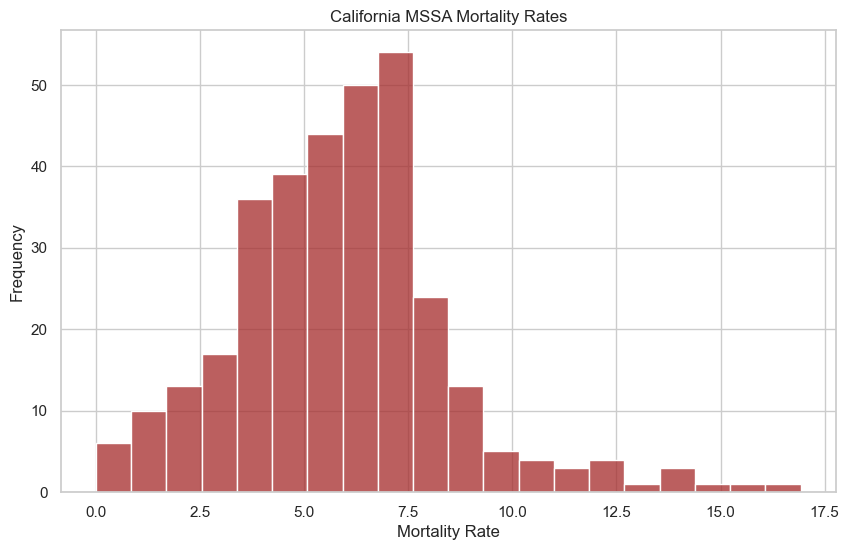

In [12]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", palette="pastel")
sns.histplot(mortality_rates.RAMR, kde = False, color ='brown')
plt.title('California MSSA Mortality Rates')
plt.xlabel('Mortality Rate')
plt.ylabel('Frequency')

plt.show()

# Score Calculation

Main components:
- Weighted poverty
- Hospital point density
- CMI
- PCSA

- I want to first get the MSSA IDs, and then for each ID I want to get total MSSA area (group together tracts) and assign each tract a "weight" based on proportion of total MSSA
- use weight to get representative mortality rate

- estimated UTM crs is EPSG:32610

In [59]:
def find_nearest_hospital(row, hostpials_gdf, geom_col='geometry', src_column=None):
    nearest_geom = nearest_points(mask, hostpials_gdf.unary_union)[1]
    # Get the corresponding value from the src_column
    nearest_row = hostpials_gdf.loc[hostpials_gdf.geometry == nearest_geom]
    # if src_column:
    #     return nearest_row[src_column].values[0]
    # else:
    #     return nearest_geom

    return nearest_row

## Supporting Functions

In [50]:
MSSA_areas

,OBJECTID,TRACT,MSSA_ID,MSSA_NAME,PCT100POV,PCT200POV,geometry
0,1,4427.00,2i,Fremont South/Mission San Jose/Newark South/Wa...,3.3,6.871438,"POLYGON ((-122.00535 37.53990, -122.00469 37.5..."
1,2,4428.00,2i,Fremont South/Mission San Jose/Newark South/Wa...,11.7,28.021802,"POLYGON ((-121.98306 37.52844, -121.98319 37.5..."
2,3,2049.20,78.2h,Boyle Heights Central/City Terrace West,27.5,62.798902,"POLYGON ((-118.19228 34.02032, -118.19228 34.0..."
3,4,2051.10,78.2h,Boyle Heights Central/City Terrace West,46.4,82.649044,"POLYGON ((-118.21123 34.02447, -118.21033 34.0..."
4,5,2051.20,78.2h,Boyle Heights Central/City Terrace West,38.9,77.784140,"POLYGON ((-118.20853 34.02327, -118.20837 34.0..."
...,...,...,...,...,...,...,...
31,8032,0013.03,116k,Brea West/Fullerton North/La Habra,14.0,30.000000,"POLYGON ((-117.94374 33.91734, -117.94422 33.9..."
32,8033,0013.04,116k,Brea West/Fullerton North/La Habra,11.4,56.798069,"POLYGON ((-117.93644 33.91735, -117.93652 33.9..."
33,8034,0014.01,116k,Brea West/Fullerton North/La Habra,13.3,32.933166,"POLYGON ((-117.93164 33.94608, -117.93165 33.9..."
34,8035,3672.00,18g,El Cerrito/El Sobrante/Kensington/Richmond Nor...,20.7,43.299571,"POLYGON ((-122.32257 37.96634, -122.32292 37.9..."


In [41]:
MSSA_ids = list(MSSA_areas.MSSA_ID.unique())
len(MSSA_ids)

542

In [147]:
MSSA_areas = MSSA_areas.to_crs('EPSG:32610')

In [148]:
MSSA_ids = MSSA_ids[0:10]

In [149]:
empty_mssas = []
for mssa_id in MSSA_ids:
    print(mssa_id)

    # Select MSSA tracts
    MSSA_tracts = MSSA_areas.query(f'MSSA_ID == "{mssa_id}"').copy()

    # Calculate area in square kilometers
    MSSA_tracts['area_sq_km'] = MSSA_tracts.area / 1e6
    MSSA_tracts['area_proportion'] = MSSA_tracts['area_sq_km'] / MSSA_tracts['area_sq_km'].sum()

    # Calculate area-weighted poverty rate
    PCT100POV_weighted_factor = sum(MSSA_tracts['PCT200POV'] * MSSA_tracts['area_proportion'])

    # Create mask for MSSA tracts
    mask = MSSA_tracts.unary_union

    # Find hospitals within the MSSA area
    hospitals_within = hospitals[hospitals.geometry.within(mask)]
    if len(hospitals_within) == 0:
        print('NO HOSPITALS IN MSSA')
        empty_mssas.append(mssa_id)
    else:
        print('HOSPITALS IN MSSA')

    # Calculate distance to nearest hospital
    outside_hospitals = hospitals[~hospitals.isin(hospitals_within)].dropna()
    target_obj = find_nearest_hospital(mask, outside_hospitals).geometry.iloc[0]
    distance = mask.distance(target_obj) / 1000

print("MSSAs without hospitals:", empty_mssas)


2i
NO HOSPITALS IN MSSA
78.2h
NO HOSPITALS IN MSSA
78.2ff
NO HOSPITALS IN MSSA
78.2ffff
HOSPITALS IN MSSA
78.2mmm
NO HOSPITALS IN MSSA
78.2e
NO HOSPITALS IN MSSA
78.2g
HOSPITALS IN MSSA
78.2f
HOSPITALS IN MSSA
78.2a
NO HOSPITALS IN MSSA
2j
NO HOSPITALS IN MSSA
MSSAs without hospitals: ['2i', '78.2h', '78.2ff', '78.2mmm', '78.2e', '78.2a', '2j']
